# Baran Akyol's perspective on G.U. Data Challenge

# Initial Steps

## Import necessary packages

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import re
import warnings
import statsmodels.api as sm
import seaborn
from arch.unitroot import PhillipsPerron
from scipy.stats.stats import pearsonr
from sklearn import linear_model
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import tweepy 
from tweepy import OAuthHandler
from textblob import TextBlob
%matplotlib inline

## Import and format Data

In [4]:
financials = pd.read_csv("Financials.csv",index_col=0)
stockprice = pd.read_csv("StockPrice.csv",index_col=0)
y = stockprice.iloc[1:9,0].values

def format_data(data):
    """ Create data dictionary.
    Creates a "function friendly" dictionary of Series objects with 
    'float32' dtype and without NA values.
    Parameters
    ----------
    data: DataFrame
        A pandas DataFrame containing the raw data
    Returns
    -------
    value_dict: dict
        A python dictionary containing values as Series objects
    """
    data = data.fillna('')
    value_dict = {}
    # Get rid of the commas(',') so they can be converted to float and iterate trough every row
    for name,row in data.replace({',':''},regex=True).iterrows():
        #if 
        if row[3] != '':
            
            value_dict[re.sub(' ',''," ".join(re.findall("[a-zA-Z]+", name)))] = \
                                                pd.Series(row[0:8],dtype='float32').values
  
    return value_dict

In [5]:
value_dict = format_data(financials)

print('Features: ',value_dict.keys())
print('Values for Total Assets: ',value_dict['TotalAssets'])
print('Type of dict object: ', type(value_dict['TotalAssets']))
print('Type of item in dict object: ',type(value_dict['TotalAssets'][0]))

Features:  dict_keys(['NetIncome', 'TotalAssets', 'TotalEquityCap', 'TierIRatio', 'RiskBasedCapitalRatio', 'LiquidityRatio', 'NPLsTotLns'])
Values for Total Assets:  [ 31272894.  30355360.  30615812.  30146710.  28953664.  28881488.
  27613620.  27159712.]
Type of dict object:  <class 'numpy.ndarray'>
Type of item in dict object:  <class 'numpy.float32'>


# Notes for this section:

* Ok, I think this looks a lot complexer than it actually is and was pretty fast and straightforward.. to write but still was a bit uncalled for as typing the data points manually would at any rate be faster.


* The point however is to have something that generalizes. This  assignment was for 1 company with 7 features but this code can analyze 1000 companies with 1000 features<br>

# CREDIT  RISK ASSESSMENT  BASICS
### Important Note:
I didn't realize that data started from 2015 and moved back in time until it was too late. I am much more used to having it the other way around and did the analysis thinking it started from an earlier time and moved forward. I figured I didn't need to redo everything I did though as it doesn't really make any difference for the purposes of you seeing how I'd do the analysis. Hope its fine. Sorry.

## Financial Analysis
### Trends

<br>We don't have enough data points to make strong analysis and the origin of our Time Series data is not that far from the present day. As such, we might (erroneously) label the inital phase of seasonality or a cycle as a trend. However, for the purposes of this assignment I will make the assumption that our series doesn't have seasonality or a cycle. There is also not enough data points to sufficiently test for drift. With more data we could fit an ARIMA model and see check the significance(or lack thereof) of the Moving Average components for drift.

There are two types of trend:
* Deterministic Trend
* Stochastic Trend

<br>Deterministic Trend is best understood(in my opinion) by graphing the data. To make things easier I will also plot a line of best fit and print its parameter values. I will also plot the Auto Correlation Function. If there is a trend in the data ACF will indicate non-stationarity as the lags increase.

<br>Stochastic Trend tests usually require a lot more data points as more lags might be required for a better model but I will still check for it as very confident p values may be indicative of a stochastic trend. For this I will use the  Phillips Perron test which performs better on smaller data points as it does not use lagged values for regression but uses 'tau' as a default and as such is similar to Augmented Dicky Fuller test which performs well on scarce data. Even then, it is not good practice to use a unit root test with this many points. However, by running the test twice, once without accounting for a deterministic trend and once accounting for it, we can at least use the test to double-check the existence of a deterministic trend.



In [299]:
def check_trend(series, acf=1,true_axis=1,pptest=1):
    """Check Trend
    
    Parameters
    ----------
    acf: boolean
        Draw graph of auto correlation function 
    true_axis: boolean
        Include full y range in y axis for true scale
    pptest: boolean
        Run Phillips Perron test
    """
    x= range(1,9)
    
    plt.scatter(x,series)
    m, b = np.polyfit(x, series, 1)
    plt.plot(x, m*x + b, '-')
    plt.title('Trend')
    plt.show()
    print('Slope: ',m)
    print('Ratio of Slope: ',m/np.mean(series))
    
    if true_axis:
        plt.scatter(x,series)
        plt.ylim([0,max(series)*1.2])
        m, b = np.polyfit(x, series, 1)
        plt.plot(x, m*x + b, '-')
        plt.title('Full y range')
        plt.show()
    
    try: 
        if acf:
            acf = pd.DataFrame(sm.tsa.stattools.acf(series), columns=['ACF'])
            plt.bar(range(1,8),acf[1:].values,0.45,label='ACF')
            plt.title('Autocorrelations')
            plt.legend()
            plt.show()
    except TypeError as TE:
        print(TE)
        pass
        
    if pptest:
        pp = PhillipsPerron(series)
        pp.trend ='c'
        print(pp.summary().as_text())
        pp.trend = 'ct'
        print(pp.summary().as_text())
        
        

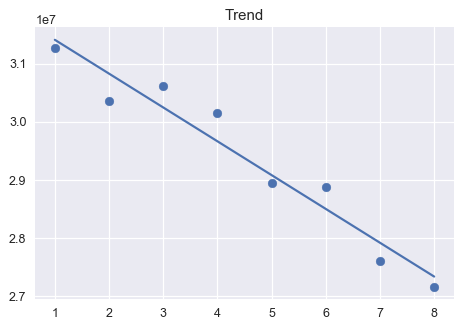

Slope:  -582107.047619
Ratio of Slope:  -0.0198164721952


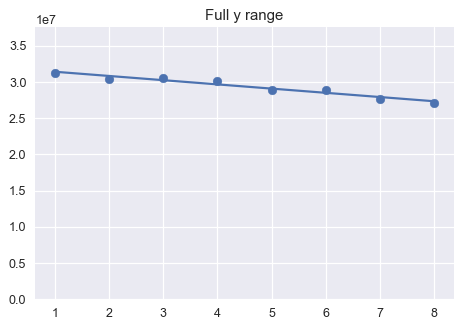

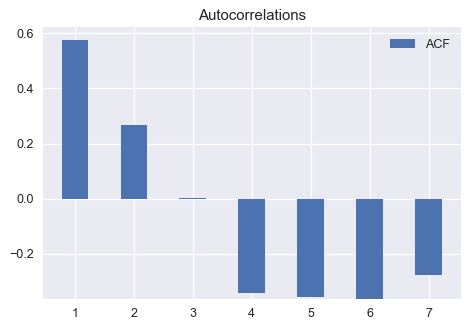

     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.914
P-value                         0.993
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -4.94 (1%), -3.48 (5%), -2.84 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.574
P-value                         0.292
Lags                                7
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -6.22 (1%), -4.35 (5%), -3.64 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [294]:
check_trend(value_dict['TotalAssets'])

    As we can see the deterministic trend is quite visible from the first graph and also noticeable in the second. Phillips Perron test also confirms the existence of a trend with 99.3% confidence. Once we detrend the series and run the phillips perron test again thus checking for stochastic trend only, this confidence reduces to 29.2% which confirms once again the existence of a deterministic trend. A p value of 0.292 is usually indicative of a stochastic trend and auto correlations does not seem to converge to zero as we move back in lags so it is safe to say that the series have an underlying stochastic trend as well. Considering the low number of data points however, it is better to proceed with caution.

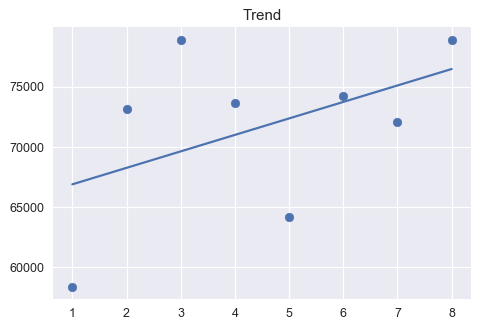

Slope:  1367.30952381
Ratio of Slope:  0.0190738581825


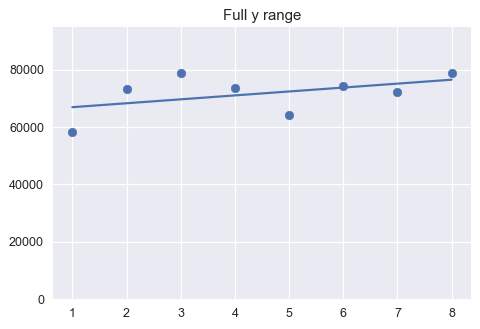

Error with ACF
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.815
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -4.94 (1%), -3.48 (5%), -2.84 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.733
P-value                         0.001
Lags                                7
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -6.22 (1%), -4.35 (5%), -3.64 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


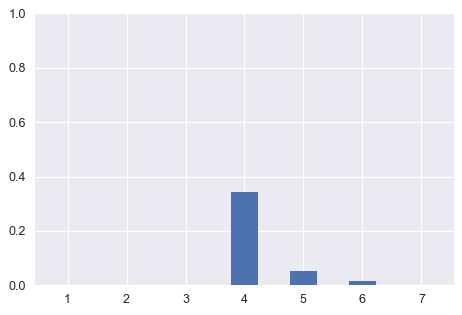

In [295]:
check_trend(value_dict['NetIncome'])

    The line of best fit of the first graph was indicative of a trend but the data points look randomly spread so we must be skeptic. Considering this random spread, the low number of data points and the high volatility of our data, the trend could easily caused by outliers in the data. Phillips Perron test which accounts for variance tells us with great confidence that the data doesn't have  a trend. The steep slope of the line of best fit in the first graph is most likely caused by the volatility that the seeming seasonality brings. our AC plot seems to confirm this but we also got an error so although the error might be related to the lack of autocorrelation on our data, it is best not to take the AC graph into account. However we can note that the error is a TypeError and has to do with isfinite function of numpy which is indicative of an edge case regarding the autocorrelation and as such supports my assumption that it has to do with the data lacking proper conditions for an acf to be fit.  Regardless, best call would be to say that there is no deterministic nor stochastic trend in the data. With more data we could  check for seasonality and de seasonalize the series by fitting a first order differenced AR model. Then we could say whether this seeming trend is indicative of anything or mere white noise from the seasonality.

* Any other variable can be analyzed with the same approach. Considering that this assignment is already lengthy I preferred not to include an extensive analysis for the rest. I checked them all myself. TotalEquityCap has deterministic trend and no stochastic trend with quite certainity and the rest seem to follow a similar pattern with NetIncome and do not have trends.

## Regression Analysis

* For regression I will be checking the effect of the feature values in a quarter on the price at the end of Quarter. Since returns are functions of price there is nothing to be gained from using them. 


* To check linear relationship I will use person correlation coefficient; more specifically pearsonr from scipy package which returns the coefficient and the p value for non-colinearity test. 


* In addition I will fit a linear regression function as well as a polynomial one and compare the size Root mean squared error with that of my target variable.


* I think a simple linear regression with polynomial features suffices for this data as more complicated models might easily overfit the dataset and fail to be indicative of anything

In [313]:
stock = stockprice.iloc[1:9,0].values

def LinearRegression(features,targets,poly=1):
    X = features.reshape(8,1)
    y = targets.reshape(8,1)
    

    pr = pearsonr(X,y)
    print('Correlation Coefficient: ',pr[0])
    print('p-value for Non-Correlation: ',pr[1])
    
    lr = linear_model.LinearRegression()
    lr.fit(X,y)
    lrprediction = lr.predict(X)
    print('RMSE: ',mean_squared_error(lrprediction,y))
    
    if poly:
        model = make_pipeline(PolynomialFeatures(2), lr)
        model.fit(X,y)
        polyprediction = model.predict(X)
        print('RMSE for polynomial: ',mean_squared_error(polyprediction,y))
    
    print('mean stock price : ',np.mean(targets))



In [315]:
for key in value_dict.keys():
    print('----------Stats for ' + key + '----------')
    LinearRegression(value_dict[key],stock)

----------Stats for TierIRatio----------
Correlation Coefficient:  [ 0.32804339]
p-value for Non-Correlation:  [ 0.42762101]
RMSE:  36.7210541565
RMSE for polynomial:  36.4389497587
mean stock price :  62.89625
----------Stats for TotalAssets----------
Correlation Coefficient:  [ 0.37679507]
p-value for Non-Correlation:  [ 0.35753025]
RMSE:  35.3070816769
RMSE for polynomial:  32.237903053
mean stock price :  62.89625
----------Stats for NPLsTotLns----------
Correlation Coefficient:  [-0.02980039]
p-value for Non-Correlation:  [ 0.94415734]
RMSE:  41.112680327
RMSE for polynomial:  40.5648136971
mean stock price :  62.89625
----------Stats for LiquidityRatio----------
Correlation Coefficient:  [-0.38696745]
p-value for Non-Correlation:  [ 0.34361461]
RMSE:  34.9873824929
RMSE for polynomial:  33.6195291563
mean stock price :  62.89625
----------Stats for RiskBasedCapitalRatio----------
Correlation Coefficient:  [-0.15706822]
p-value for Non-Correlation:  [ 0.71030491]
RMSE:  40.1340545

    Analyzing these values is pretty straightforward NPLsTotLns with a p value of 0.94 for the test of non-correlation also displays highest RMSE and TotalEquityCap seems to be the feature which has the highest effect on stock price. 

## Sentiment Analysis

For this part I will be doing a sentiment analysis using TextBlob on data from twitter. Twitter has a nice api called tweepy which is pretty straightforward to use.

* I chose twitter as my source because it provides ample data which is relatively bias free as its user base is very diverse. 


* Instead of using sentiment score for every word I first look at the sentiment of the tweet as a whole and only then move on to select those words whose sentiment matches that of the tweet as a whole. The point of doing this was to make sure that the sentiment of the words represent the purpose with which they were spoken. 


* Consider the following sentence: " People hate X but I love and adore X". We could list hate as a word said about X but it isn't representative of the actual sentiment of the person. As such looking at the sentiment of the tweet first would be a good heuristic for avoiding such errors. 


In [91]:

class TwitterSentimentAnalysis(object):
    
    
    def __init__(self):
        
        api_key = 'r3QAlQyZkD4iZWNgpBXlJWGex'
        api_secret = 'Va4OErWVfHxilTMcqh8T1NfV1exQioRoxpvVCtHTHuflVoa2v5'
        access_token = '118780162-w0yITP6i2OeuGSXx4mw1okUq9eO7Mil7iylTUfPg'
        access_token_secret = 'UZUKCZJGKk5phsUgt8JlfLJPC4z8D16Z8nHad2bCfMggH'

        try:
            self.auth = OAuthHandler(api_key, api_secret)
            self.auth.set_access_token(access_token, access_token_secret)
            self.api = tweepy.API(self.auth)

        except:
            print("Error: Authentication Failed")
    
    
    def clean_tweet(self, tweet):
        
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def get_sentiment(self, tweet):


        analysis = TextBlob(self.clean_tweet(tweet))

        if analysis.sentiment.polarity > 0:
            return 'positive'

        elif analysis.sentiment.polarity < 0:
            return 'negative'
                       
        else: 
            return 'neutral'
                               

    def get_tweets(self, query, count = 100):
        
        tweet_list=[]
        
        try:

            fetched_tweets = self.api.search(q = query, count = count)


            for tweet in fetched_tweets:

                parsed_tweet = {}

                parsed_tweet['text'] = tweet.text

                parsed_tweet['sentiment'] = self.get_sentiment(tweet.text)


                if tweet.retweet_count > 0:

                    if parsed_tweet not in tweet_list:
                        tweet_list.append(parsed_tweet)
                else:
                    tweet_list.append(parsed_tweet)


            return tweet_list

        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
                       
                
    def get_words(self, query, count=100):

        word_dict = {}
        positive = []
        negative=[]
        
        try:
            
            tweet_list = self.get_tweets(query=query,count=count)
            for tweet in tweet_list:

                tokenized = RegexpTokenizer(r'\w+').tokenize(tweet['text'])

                if tweet['sentiment'] == 'positive':

                    positive += [word for word in tokenized if TextBlob(word).sentiment.polarity > 0]

                elif tweet['sentiment'] == 'negative':

                    negative += [word for word in tokenized if TextBlob(word).sentiment.polarity < 0] 

            word_dict['positive']=set(positive)
            word_dict['negative']=set(negative)
            
            return word_dict
        
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
        

In [92]:
api = TwitterSentimentAnalysis()
words1 = api.get_words(query='Bank of Oklahoma')
words2 = api.get_words(query='BOKF')
print(words1)
print(words2)

{'negative': {'hate'}, 'positive': {'more', 'old', 'new', 'First', 'love', 'thanks', 'awesome', 'Lol', 'OK'}}
{'negative': {'Expected', 'previously', 'failed'}, 'positive': {'top', 'more', 'new', 'best', 'High', 'Strong', 'Better', 'love', 'awesome', 'excellent', 'More', 'able', 'Happy', 'free', 'New', 'secure', 'OK'}}


    People didn't have much bad things to say about Bank of Oklahoma which is nice but our data is also assymetrical which might be undesirable. We can always  hand pick some sources which we know a-priori to have negative sentiment and use the same(a very similar) algorithm to make our data more symmetric, if that is wanted. I think the percentages of positive and negative sentiments also provide useful information and is actually a desirable characteristic.

#### We can also check  the tweets  and their sentiment

In [93]:
api = TwitterSentimentAnalysis()
api.get_tweets(query='BOKF')

[{'sentiment': 'neutral',
  'text': 'هل تعلم ! كيف يموت الجن و كم تبلغ أعمارهم . سبحان الله\nهنا\nhttps://t.co/bIgPfkJD08\n#احلي_مالقيت_بتويتر\nBOKF https://t.co/PUPZsKyi9d'},
 {'sentiment': 'positive',
  'text': '#Tulsa #OK #USA - Senior Banking Center Manager 71st HWY 75 - Consumer Banking BOK Financial BOKF Hea... https://t.co/7YZDDJefuo #WORK #JOB'},
 {'sentiment': 'neutral',
  'text': 'BOK Financial $BOKF Earning Favorable Press Coverage, Analysis Finds https://t.co/A4hM3IdDs9'},
 {'sentiment': 'negative',
  'text': '$384.08 Million in Sales Expected for BOK Financial Co. $BOKF This Quarter https://t.co/qUmODm8vZo'},
 {'sentiment': 'neutral',
  'text': 'Shell Asset Management Co. Sells 824 Shares of BOK Financial Co. $BOKF https://t.co/T0QEC5CSV5'},
 {'sentiment': 'neutral',
  'text': '又吉の劇場買ってきました〜\n登場する女の子の出身が青森という設定！それだけで嬉しい😊'},
 {'sentiment': 'neutral',
  'text': 'BOK Financial Co. $BOKF EVP Donald T. Parker Sells 7,650 Shares of Stock https://t.co/ypC7N7tIal #stocks'},
 {'sen

    At first I was worried that the query was returning erronaeous results but turns out BOK Financials own Bank of Oklahoma so I guess you meant BOK Financials when you said BOKF? Considering this I didn't revise search criteria. Don't think it is too big of a problem though as we can always get those tweets which specifically have @BankOfOklahoma or whatever the hashtag is.

# Credit Summary

## NLG

In [276]:

def nlgfordata(frame):

    def map_trend(frame):

        data = frame.values[0:8]

        trend = []

        for i in range(1,len(data)):

            if data[i] > data[i-1]:

                trend.append('down')

            elif data[i] < data[i-1]:

                trend.append('up')

            else:

                trend.append('same')

        return trend[::-1]



    def construct_beginning(frame):
        beginning = []
        beginning.append(frame.name + ' has trended ')
        return beginning



    def direction_and_number(x,direction):

        if x > 1:
            return direction + " for " + str(x) + " quarters "
        else:
            return direction + " for " + str(x) + " quarter "




    def construct_middle(trend):

        middle = []


        direction = trend[0]
        micro_counter = 1
        macro_counter = 1

        for item in trend[1:]:

            if item == direction:
                micro_counter += 1
                if macro_counter > len(trend)-2:
                    middle.append(direction_and_number(micro_counter-1,direction))
                
            else:
                middle.append(direction_and_number(micro_counter,direction))
                direction = item
                micro_counter = 1

                if macro_counter < len(trend)-1:
                    middle.append(', then ')

            macro_counter +=1
            
        return middle 

    def adjective(frame):
        data = frame.values[8:10]
        data = re.sub('-','',data[1])
        integer = re.sub('%','',data)

        if int(integer) > 30:
            return 'substantially'

        elif int(integer)>15:
            return 'considerably'

        elif int(integer) <= 15:
            return 'slightly'




    def construct_end(trend,frame):

        data = frame.values[8:10]
        end = []

        changedto = '$' + frame.values[0][0:4] + 'bn'
        qoq = '$' + str(math.ceil(float(re.sub(',','.',re.sub('-','',data[0])))*10) /10) + 'mm'



        if trend[-1] == trend[-2]:

            if trend[-1] == 'up':

                end.append('and this quarter it also increased, ' + \
                                      adjective(frame) + \
                           ', by ' + qoq + ' to '  + changedto +  \
                           ', an increase of '+str(data[1]))


            elif trend[-1] == 'down':

                end.append('and this quarter it also decreased, '  + \
                                      adjective(frame) + \
                           ', by ' + qoq + ' to '  + changedto +  \
                           ', a decrease of '+ re.sub('-','',str(data[1])))

        elif trend[-1] != trend[-2]:

            if trend[-1] == 'up':

                end.append('but this quarter it  increased, '  + \
                                      adjective(frame) + \
                           ', by ' + qoq + ' to '  + changedto + \
                           ', an increase of '+str(data[1]))


            elif trend[-1] == 'down':

                end.append('but this quarter it  decreased, '  + \
                                      adjective(frame) + \
                           ', by ' + qoq + ', to '  + changedto +   \
                           ', a decrease of ' + re.sub('-','',str(data[1])))

        return end

    
    trend = map_trend(frame)
    beginning = construct_beginning(frame)
    middle = construct_middle(trend)
    end = construct_end(trend,frame)
    
    total = beginning + middle + end
    
    sentence = str()
    for string in total:
        sentence += string
        
    return sentence
    

    Ok, so I bet this code is full of bugs and might not work for everything. I had a lot of fun writing it but it is merely an ad-hoc solution and a first attempt. It works fine for the values we have at hand as far as I can tell. 
 
 
    Only bug I could catch was with NPLs, although the change is %48 the data says that delta change is 0.0 so the code tells that there was a big change of 0.0mm. I think stuff like these can be handled with a final wrapper but I don't have time to think and write something like that. 
 
### Take a look:


In [277]:
row_index_with_actual_data = [1,4,7,8,9,12,15]

for index in row_index_with_actual_data:
    
    frame = financials.iloc[index,:]
    print(nlgfordata(frame))
    print( '----------------------------------' )

Total Assets has trended up for 5 quarters , then down for 1 quarter but this quarter it  increased, slightly, by $917.6mm to $31,2bn, an increase of 3%
----------------------------------
Net Income has trended down for 1 quarter , then up for 1 quarter , then down for 1 quarter , then up for 2 quarters , then down for 1 quarter and this quarter it also decreased, considerably, by $14.8mm to $58,3bn, a decrease of 20%
----------------------------------
Total Equity Cap has trended up for 6 quarters but this quarter it  decreased, slightly, by $151.6mm, to $2,75bn, a decrease of 5%
----------------------------------
Tier I Ratio has trended up for 2 quarters , then down for 1 quarter , then up for 3 quarters but this quarter it  decreased, slightly, by $0.7mm, to $10.2bn, a decrease of 6%
----------------------------------
Risk Based Capital Ratio has trended up for 1 quarter , then down for 2 quarters , then up for 1 quarter , then down for 1 quarter , then up for 1 quarter but this qu

### Notice

* The adjective after "and this quarter it also decreased" is dynamic and changes according to the extend of change. I set it quite arbitrarily to say "slightly" below 15 percent, "considerably" between 15 and 30 and "substantially above 30. I suppose I could pick better adjectives but I guess you get the point.


* The grammar of the last sentence is dependent on the previous sentence and conjunctions such as "and" or "but" are being used (almost) properly.


* I tried adhering to simple grammar rules such as using quarters for plural and quarter for singular numbers. 


* I used a different sentence structure than the one you suggested in the assignment but it is only because I arbitrarily picked these as I went along and don't think it matters to change it as the point I think is to get other stuff right.


* This can be improved substantially given more time. Constructing a class would be better and dealing with all these grammar rules I appreciate the benefit of using an NLG library.

# Getting to know me

* #### What is a passage, book, sentence, or article that has meant the most in developing your character, moral compass, strength, and compassion for others?

     This is quite difficult for me to answer as there are countless books, sentences, articles that shaped who I am. I always defended the value of an eclectic approach to knowledge and diversity of interests. As such I can't really compare things like my interest in philosopy during High-School or my interest in the role physical forces play in natural morphology.I doubt I would find such beauty in natural sciences if it wasn't for the poetry of Nazim Hikmet. It is often the case that one  is meaningless without the rest and the whole is more than the sum of its parts. So with apologies I would at least like to narrow it down to three books which had a very definitive impact on me.

     ##### 1- Douglas Adams - Hitchhiker's Guide to the Galaxy
        Although this is a sci-fi satire whose genre is literally "literary none-sense", I consider it among the most philosophical books I ever read in which  the answer to the "Question of Life the Universe and Everything" is claimed to be "42". Douglas Adams has a very unique perspective. His total disregard for anything serious and his mockery of the search for meaning is far from nihilistic as some would claim but simply a celebration of the absurdity of life. He makes the case that things are often multi dimensional and the universe is mind boggling. The questions we ask can be more important than the asnwers we got and meaning can be slowly weaved into things with work. He taught me to think outside the box, have a holistic perspective and enjoy the ride.
   
     ##### 2- Richard Dawkins- The Selfish Gene
        I owe the justification of my ethical principles to this book. It is a very comprehensive investigation of natural selection and evolution using game-theory as a framework. The final conclusion, which Dawkins empirically proves over and over is that Altruism or as he puts it "Selfish Altruism" is one of the best survival strategies nature has ever produced. Being a good person, before anyone, benefits you the most and communities full of altruistic individuals thrive.
   
     ##### 3- Karl Popper- The Logic of Scientific Discovery
        This is the last philosophy book I  read. When I read it in sophmore year, it filled a void that I was so desperately trying to fill for years.  Karl Popper starts from the long lasting problem of induction and introduces very sound principles for the creation of knowledge. Among these are the principle of Falsifiability, which states that for anything to be scientific it must be falsifiable. Although this sounds simple, it is very effective and the way everything is connected and explained in the book has made me appreciate and understand science in a very different level and definitely expanded the way I think.


* #### Tell me about something you’ve done to help improve the life of another person.

    I was very verbose in answering the first question so I will try to keep the remaining two short. I was lucky enough to have good fundemental education as both my elementary school and high school were top ranked schools. During my undergraduate years I saw how important this was as some courses which seemed so intuitive to me caused nightmares to others. Many good students had monetized their intuition/hard-work and would offer private tutoring. Some students however barely made ends meet as is let alone be able to pay the high fees those students asked for. So I offered classes to anyone interested before exams, free of charge. I had quite high attendence rates. In the end the appreciation of those I taught was more than enough reward for me.
    
    
* #### What are your best personality traits that are relevant to the role (e.g. determination, agreeability)?

    A trait that I value greatly is creativity. I have always been reserved towards authority and tried to become my own person and have my own unique thoughts. I also value honesty, mainly the honesty of a person to himself. I try really hard to keep myself free of bias and remain objective. This hard task requires constant inward observation which in turn helps me be rid of the cyclical, lazy ways of thinking. It also helps make me be a more amicable person.
